## **1. Pre-processing**

In [ ]:
# Mounting the drive and downloading relevant packages
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the data set
fifa = pd.read_csv('/content/drive/Shared drives/BA305/csv/players_22.csv')
fifa.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (25,108) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,...,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,...,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,...,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,...,50+3,50+3,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,...,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png


In [ ]:
# Grouping the columns by categories
clmn = ['player_positions','height_cm','weight_kg']

attacking = [col for col in fifa if col.startswith('attacking')]
movement = [col for col in fifa if col.startswith('movement')]
power = [col for col in fifa if col.startswith('power')]
defending = [col for col in fifa if col.startswith('defending')]
skill = [col for col in fifa if col.startswith('skill')]

data = fifa[clmn]
attacking = fifa[attacking]
movement = fifa[movement]
power = fifa[power]
defending = fifa[defending]
skill = fifa[skill]

# Dropping skill moves
skill=skill.drop('skill_moves',axis=1)

df = pd.concat([data,attacking,skill,movement,power,defending], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_positions             19239 non-null  object 
 1   height_cm                    19239 non-null  int64  
 2   weight_kg                    19239 non-null  int64  
 3   attacking_crossing           19239 non-null  int64  
 4   attacking_finishing          19239 non-null  int64  
 5   attacking_heading_accuracy   19239 non-null  int64  
 6   attacking_short_passing      19239 non-null  int64  
 7   attacking_volleys            19239 non-null  int64  
 8   skill_dribbling              19239 non-null  int64  
 9   skill_curve                  19239 non-null  int64  
 10  skill_fk_accuracy            19239 non-null  int64  
 11  skill_long_passing           19239 non-null  int64  
 12  skill_ball_control           19239 non-null  int64  
 13  movement_acceler

In [ ]:
# Taking only one position (the first one) from player positions
df["player_positions"]=df["player_positions"].str[:3]
df["player_positions"]=df["player_positions"].str.replace(",","")

# Grouping the positions into three categories- midfield, forward and defense
df.loc[(df['player_positions'] == 'RW') | (df['player_positions'] == 'LW') | (df['player_positions'] == 'CF') | (df['player_positions'] == 'ST') , 'player_positions'] = 'forward'  
df.loc[(df['player_positions'] == 'RM') | (df['player_positions'] == 'LM') | (df['player_positions'] == 'CM') | (df['player_positions'] == 'CAM') | (df['player_positions'] == 'CDM') , 'player_positions'] = 'midfield'  
df.loc[(df['player_positions'] == 'RB') | (df['player_positions'] == 'RWB') | (df['player_positions'] == 'LB') | (df['player_positions'] == 'LWB') | (df['player_positions'] == 'CB') , 'player_positions'] = 'defender' 
df.loc[(df['player_positions'] == 'GK'),'player_positions'] = 'goalkeeper'

In [ ]:
# Drop null values- all the goalkeepers
df=df.dropna(how='any')
df=df.reset_index(drop=True)
df.head()

,player_positions,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,...,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,defending,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle
0,forward,170,72,85,95,70,91,88,96,93,...,95,86,68,72,69,94,34.0,20,35,24
1,forward,185,81,71,95,90,85,89,85,79,...,82,90,85,76,86,87,44.0,35,42,19
2,forward,187,83,87,95,90,80,86,88,81,...,74,94,95,77,77,93,34.0,24,32,24
3,forward,175,68,85,83,63,86,86,95,88,...,84,80,64,81,53,81,37.0,35,32,29
4,midfield,181,70,94,82,55,94,82,88,85,...,78,91,63,89,74,91,64.0,68,65,53


## **2. Aggregating Decision Variables**

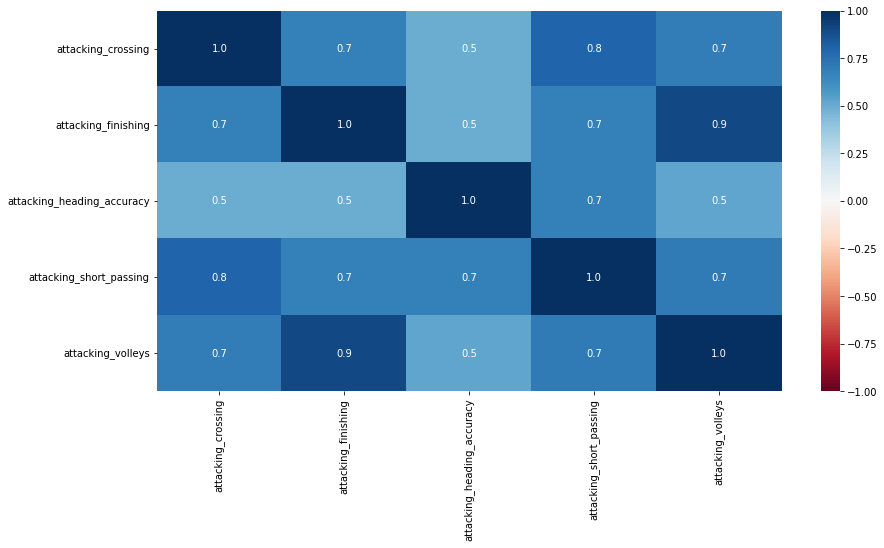

In [ ]:
# Running correlations on each category to see if each component is really correlated or not
## Correlation for attacking
corr_mat_attack = attacking.corr()
plt.figure(figsize=(14,7))
sns.heatmap(corr_mat_attack,annot=True,fmt=".1f",vmin=-1,vmax=1,cmap='RdBu');

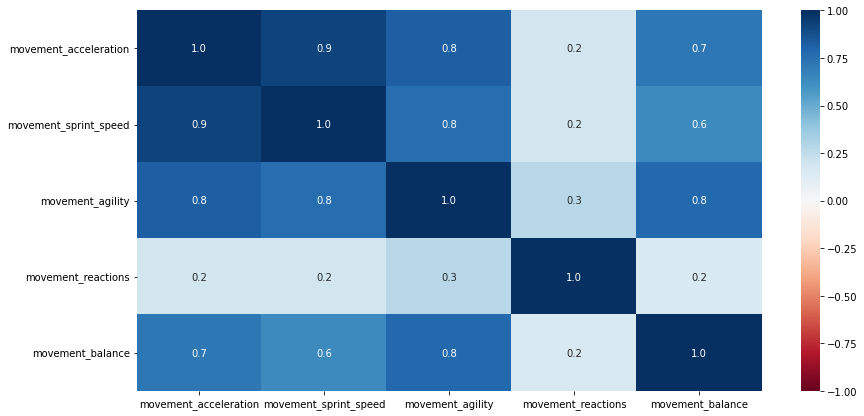

In [ ]:
## Correlation for movement
corr_mat_movement = movement.corr()
plt.figure(figsize=(14,7))
sns.heatmap(corr_mat_movement,annot=True,fmt=".1f",vmin=-1,vmax=1,cmap='RdBu');

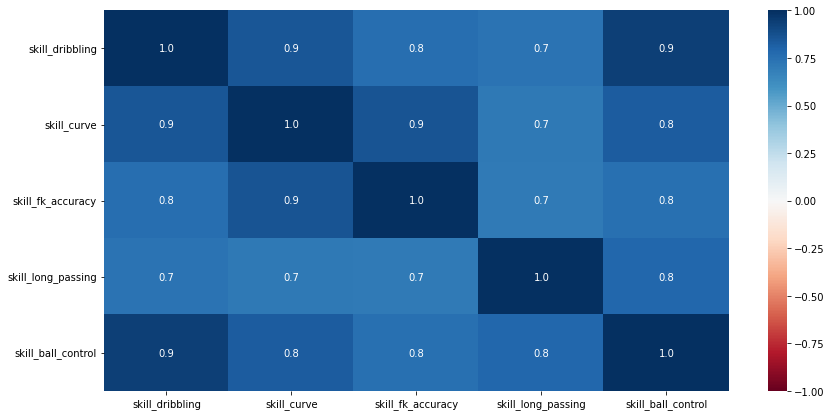

In [ ]:
## Correlation for skill
corr_mat_skill = skill.corr()
plt.figure(figsize=(14,7))
sns.heatmap(corr_mat_skill,annot=True,fmt=".1f",vmin=-1,vmax=1,cmap='RdBu');

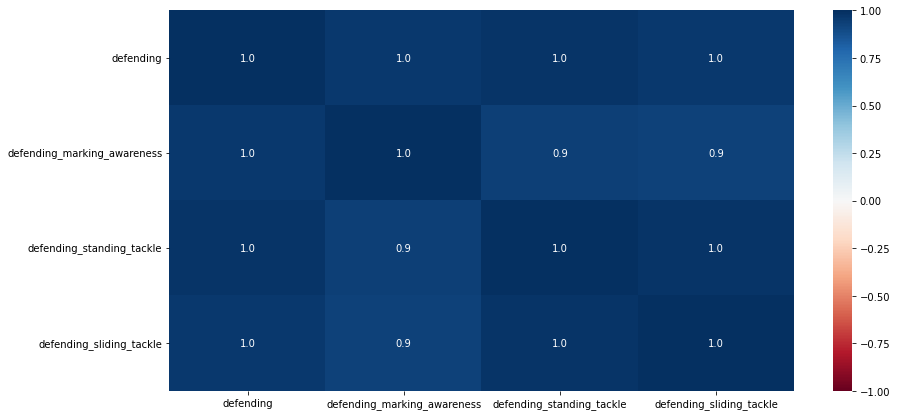

In [ ]:
## Correlation for defense
corr_mat_defence = defending.corr()
plt.figure(figsize=(14,7))
sns.heatmap(corr_mat_defence,annot=True,fmt=".1f",vmin=-1,vmax=1,cmap='RdBu');

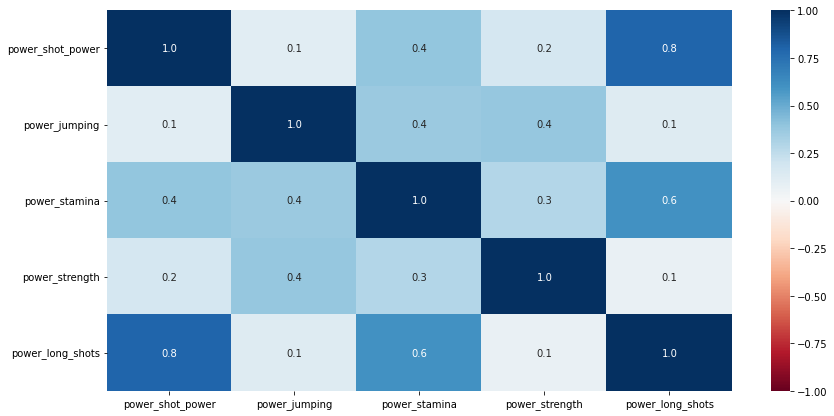

In [ ]:
## Correlation for power
corr_mat_power = power.corr()
plt.figure(figsize=(14,7))
sns.heatmap(corr_mat_power,annot=True,fmt=".1f",vmin=-1,vmax=1,cmap='RdBu');

In [ ]:
# Running PCA on the stats
dfpca = df.drop(['player_positions','height_cm','weight_kg'], axis = 1)

pcs = PCA()
pcs.fit(dfpca)
pcsSummary_dfpca = pd.DataFrame({'% of variance explained': pcs.explained_variance_ratio_,
                              'cumulative % explained': np.cumsum(pcs.explained_variance_ratio_)})
pcsSummary_dfpca.round(3)

,% of variance explained,cumulative % explained
0,0.395,0.395
1,0.274,0.669
2,0.098,0.767
3,0.054,0.821
4,0.024,0.845
5,0.021,0.866
6,0.018,0.883
7,0.016,0.900
8,0.013,0.913
9,0.011,0.924


In [ ]:
# Looking at the PCA components
var = list(dfpca.columns)
pd.DataFrame(pcs.components_.transpose(), index=[var]).round(1)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
attacking_crossing,0.2,0.2,-0.2,0.0,0.2,0.3,0.4,0.2,0.5,0.4,...,0.1,-0.0,-0.1,0.0,0.1,-0.0,-0.1,-0.0,0.0,-0.0
attacking_finishing,0.3,0.1,0.2,-0.0,0.1,-0.2,-0.2,-0.1,0.2,0.1,...,-0.2,0.2,-0.3,0.5,0.2,-0.0,-0.0,0.0,-0.0,0.0
attacking_heading_accuracy,-0.1,0.1,0.4,-0.3,0.0,-0.0,0.3,-0.1,0.1,-0.4,...,-0.1,-0.3,-0.3,0.0,-0.2,-0.1,0.0,-0.0,-0.0,-0.1
attacking_short_passing,0.1,0.2,0.0,0.0,0.1,-0.2,0.2,0.2,-0.2,-0.1,...,-0.0,0.0,0.0,-0.1,0.1,-0.0,-0.5,0.1,-0.7,0.0
attacking_volleys,0.3,0.1,0.2,0.0,-0.1,-0.1,-0.0,-0.3,0.3,-0.3,...,0.1,-0.1,0.2,-0.2,-0.1,0.0,0.0,0.0,0.0,0.0
skill_dribbling,0.2,0.2,-0.1,-0.0,0.2,-0.1,0.2,0.1,0.1,0.1,...,-0.1,0.0,0.4,-0.0,-0.5,0.0,0.4,-0.1,-0.3,0.0
skill_curve,0.2,0.2,-0.0,0.1,-0.1,0.4,0.2,-0.0,0.1,-0.1,...,-0.2,0.0,-0.3,-0.0,0.1,0.0,-0.0,0.0,-0.0,0.0
skill_fk_accuracy,0.2,0.2,0.0,0.3,-0.4,0.5,-0.1,0.1,-0.4,-0.3,...,0.0,0.0,0.2,0.1,-0.1,0.0,0.0,0.0,-0.0,-0.0
skill_long_passing,0.0,0.3,-0.0,0.1,0.1,-0.2,0.1,0.3,-0.4,0.1,...,-0.0,-0.0,-0.4,0.0,-0.1,-0.0,0.3,-0.1,0.2,-0.0
skill_ball_control,0.1,0.2,0.0,-0.0,0.2,-0.2,0.2,0.1,-0.1,-0.1,...,-0.0,0.1,0.3,-0.0,-0.1,0.0,-0.5,0.1,0.7,0.0


In [ ]:
# Creating categories with averages
data = df[clmn]
attacking = [col for col in df if col.startswith('attacking')]
skill = [col for col in df if col.startswith('skill')]
movement = [col for col in df if col.startswith('movement')]
power = [col for col in df if col.startswith('power')]
defending = [col for col in df if col.startswith('defending')]

attacking_average= df[attacking].mean(axis=1)
skill_average = df[skill].mean(axis=1)
movement_average=df[movement].mean(axis=1)
power_average=df[power].mean(axis=1)
defending_average=df[defending].mean(axis=1)

df2 = pd.concat([data,attacking_average,skill_average,movement_average,power_average,defending_average], axis=1)
df2.columns = ['player_positions','height_cm','weight_kg','attacking_average', 'skill_average', 'movement_average','power_average','defending_average']
df2.head()

,player_positions,height_cm,weight_kg,attacking_average,skill_average,movement_average,power_average,defending_average
0,forward,170,72,85.8,94.0,90.2,77.8,28.25
1,forward,185,81,86.0,81.4,81.6,84.8,35.00
2,forward,187,83,87.6,83.6,85.4,87.2,28.50
3,forward,175,68,80.6,89.2,90.2,71.8,33.25
4,midfield,181,70,81.4,88.0,80.0,81.6,62.50


In [ ]:
df3 = df2 #for use with neural network model

In [ ]:
# Observing the proportion of classes in dataset before creating model
df2[["player_positions", "height_cm"]].groupby("player_positions").agg(['count'])

,height_cm
,count
player_positions,
defender,6394
forward,3680
midfield,7033


## **3. First Model: Decision Tree**

In [ ]:
# Preprocessing

## Defining variables
x = df2.drop(columns=['player_positions'])
y = df2['player_positions']
np.unique(y, return_counts=True)

# Training & test data split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

In [ ]:
# Creating the first tree
clf_first = DecisionTreeClassifier(criterion = "gini", random_state = 1)
clf_first.fit(x_train,y_train)
y_pred_first = clf_first.predict(x_test)

## It's too complicated to print.

# Checking accuracy
y1_pred_train = clf_first.predict(x_train)
y1_pred_test = clf_first.predict(x_test)

print("Accuracy score on train:", accuracy_score(y_train, y1_pred_train)*100, "%")
print("Accuracy score on test:", accuracy_score(y_test, y1_pred_test)*100, "%")

Accuracy score on train: 100.0 %
Accuracy score on test: 72.1410481200078 %


In [ ]:
# Creating a pruned tree with optimal parameters

## Grid Search
param_grid = {
    'max_depth': [4, 5, 6, 7], 
    'min_samples_split': [40, 50, 60, 70],
    'min_samples_leaf': [100, 200, 300, 400],
    'max_leaf_nodes': [10, 16, 20],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}

gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring = 'accuracy')
gridSearch.fit(x_train, y_train)

print('Best accuracy: ', gridSearch.best_score_)
print('Parameter values to achieve best accuracy: ', gridSearch.best_params_)

Best accuracy:  0.75321564174877
Parameter values to achieve best accuracy:  {'max_depth': 6, 'max_leaf_nodes': 20, 'min_impurity_decrease': 0, 'min_samples_leaf': 100, 'min_samples_split': 40}


<Figure size 2880x1080 with 0 Axes>

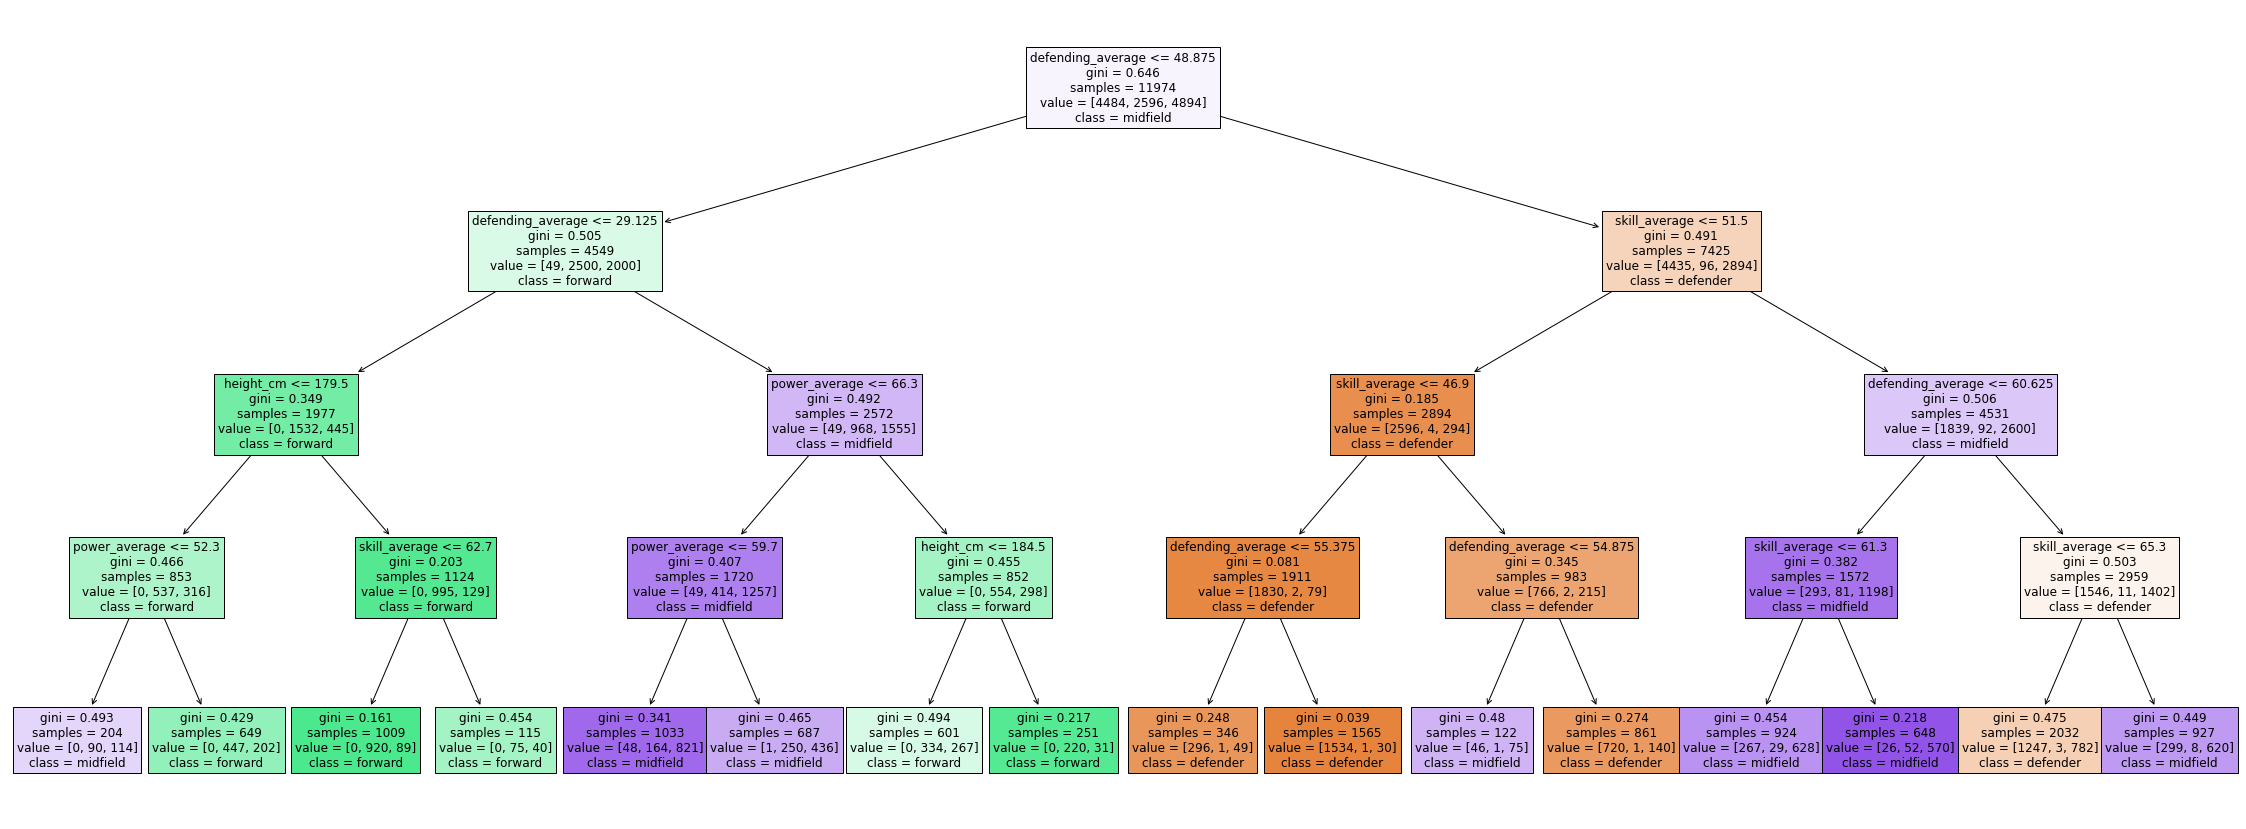

In [ ]:
# Pruning the tree
plt.figure(figsize=(40,15))

clf_final= DecisionTreeClassifier(
      max_depth = 4, # using 4 instead of 6 for interpretability
      max_leaf_nodes = 20,
      min_samples_leaf = 100,
      min_samples_split = 40,
      criterion = 'gini')
clf_final.fit(x_train, y_train)

# Plot the reduced tree
fig = plt.figure(figsize=(40,15))
names = ['defender','forward', 'midfield']
tree.plot_tree(clf_final, fontsize=12, feature_names=x.columns, class_names=names ,filled=True);

In [ ]:
# Compare confusion matrix of train and test sets
y_pred_train = clf_final.predict(x_train)
y_pred_test = clf_final.predict(x_test)

print("Accuracy score on train:", accuracy_score(y_train, y_pred_train)*100, "%")
print("Accuracy score on test:", accuracy_score(y_test, y_pred_test)*100, "%")

print("Confusion Matrix on train:")
print(confusion_matrix(y_train, y_pred_train))
print("Confusion Matrix on test:")
print(confusion_matrix(y_test, y_pred_test))

Accuracy score on train: 75.63888424920661 %
Accuracy score on test: 73.46580946814728 %
Confusion Matrix on train:
[[3797    0  687]
 [   6 1996  594]
 [1001  629 3264]]
Confusion Matrix on test:
[[1556    0  354]
 [   2  831  251]
 [ 478  277 1384]]


In [ ]:
# Gini Index for Testing
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

    defender       0.76      0.81      0.79      1910
     forward       0.75      0.77      0.76      1084
    midfield       0.70      0.65      0.67      2139

    accuracy                           0.73      5133
   macro avg       0.74      0.74      0.74      5133
weighted avg       0.73      0.73      0.73      5133



##**4. Classifying Your Own Player**

In [ ]:
## Classifying your own FIFA created player
new_player = pd.DataFrame([
{'height_cm': 177,
 'weight_kg': 68,
 'attacking_average': 44,
 'skill_average': 53,
 'movement_average': 89,
 'power_average': 91,
 'defending_average': 82,
 }
 ])

new_prediction = clf_final.predict(new_player)
print ("Your player is a", new_prediction)

Your player is a ['defender']


##**5. Extra: Neural Networks**

In [ ]:
#neural network
y = df3[['player_positions']]
x_noScale = df3.drop(columns=['player_positions'])
scaleInput = MinMaxScaler()
x = scaleInput.fit_transform(x_noScale)
x_train,x_valid,y_train,y_valid = train_test_split(x,y,test_size=.3,random_state=1)
nnet = MLPClassifier(hidden_layer_sizes=(10),activation='logistic',solver='lbfgs',random_state=1,max_iter=1000)
nnet.fit(x_train,np.array(y_train).ravel())
y_pred = nnet.predict(x_train).ravel()

#validation data
y_actualV = np.array(y_valid).ravel()
y_predV = nnet.predict(x_valid).ravel() #replace here for new data set testing
results = pd.DataFrame({'actual':y_actualV, 'predicted':y_predV})
diff = 0
for r in range(len(results)):
    if results['actual'][r] != results['predicted'][r]:
        diff += 1
print()
print('Found %d incorrect predictions' % diff)
print(f'Error rate of {(diff/len(results))*100:.02f}%')
print('Test set score: %f' % nnet.score(x_valid,y_valid))
print(results)



Found 1012 incorrect predictions
Error rate of 19.72%
Test set score: 0.802844
        actual predicted
0     midfield  midfield
1     midfield  midfield
2     midfield  midfield
3     midfield  midfield
4     defender  defender
...        ...       ...
5128   forward   forward
5129  midfield  midfield
5130  defender  defender
5131  defender  defender
5132  midfield  midfield

[5133 rows x 2 columns]


##**5. Extra: K-Nearest Neighbors**

In [ ]:
#K-Nearest Neighbors
df2["player_positions"]=pd.Categorical(df2.player_positions)
df2['positions_in_code'] = df2.player_positions.cat.codes
#defender=0,foward=1,midfielder=2
df2=df2.drop("player_positions",axis=1)
df2.head()

,height_cm,weight_kg,attacking_average,skill_average,movement_average,power_average,defending_average,positions_in_code
0,170,72,85.8,94.0,90.2,77.8,28.25,1
1,185,81,86.0,81.4,81.6,84.8,35.00,1
2,187,83,87.6,83.6,85.4,87.2,28.50,1
3,175,68,80.6,89.2,90.2,71.8,33.25,1
4,181,70,81.4,88.0,80.0,81.6,62.50,2


In [ ]:
outcome = 'positions_in_code'
predictors = list(df2.columns)
predictors.remove(outcome)

# Store predictors and target into X and y, respectively
X = df2[predictors]
y = df2[outcome]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.4, random_state=2, stratify=y)
print('Training set:', X_train.shape, 'Testing set:', X_test.shape)

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: (10264, 7) Testing set: (6843, 7)


In [ ]:
results = []
for k in range(1, 40, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, y_train)
    
    # create a dictionary to store the results
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test_scaled))
    })

# convert results to a pandas dataframe for better visualization
results = pd.DataFrame(results)
results

,k,accuracy
0,1,0.728043
1,3,0.760339
2,5,0.769838
3,7,0.778898
4,9,0.784159
5,11,0.788689
6,13,0.789420
7,15,0.791904
8,17,0.792635
9,19,0.792343


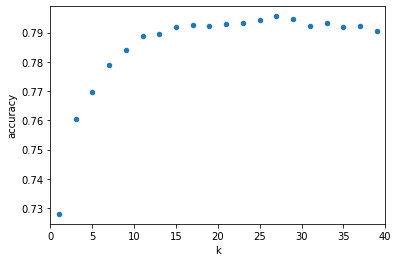

In [ ]:
results.plot.scatter(x='k', y='accuracy', xlim=[0, 40]);

In [ ]:
knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

[[2169    0  389]
 [   3 1054  415]
 [ 393  199 2221]]
Accuracy: 0.7955575040187053
